In [474]:
import os
from urllib.request import urlopen,Request
import csv
import pandas as pd 
import numpy as np
import json
import re
import requests

# Task 1: Identify one or more suitable web APIs
API Chosen:
Number of API are available for [GitHub]( https://developer.github.com/v3/repos/) I choose two API first one collect the Commits data of any organization and then second API 
is used to collect the data of developers and their respective Repositories.
Api key is as follows

    1.https://api.github.com/orgs/mozilla/repos 

    2.https://api.github.com/users/???
Second API is extracted from first API and is interlinked
Question marks means each developer has different API    

In [475]:
token = "bd158d4eb73e4cc6a841680abcf4349ea3b43c6b"

# Task 2: Collect data your chosen API(s)
Raw commits data of Developers is collected in form of JSON file

In [476]:
# Function to create a file with set headings 
def create_file (file_loc, headings): 
    with open(file_loc, "w",newline='') as write_file: #as in get_and_write_data function 
        f = csv.writer(write_file)
        f.writerow(headings)
    write_file.close()
    
#function to call the API, retreive the raw JSON object data , and write to a JSON file
# I collect Arrays of JSON object and Combine them in single Array and save again to JSON file
def get_and_write_data(link):
    results = []  # for collection of JSON objects
    req = Request(link) 
    req.add_header("Authorization", "token {}".format(token))
    req.add_header('Accept', 'application/vnd.github.v3+json')
    response = urlopen(req) 
    raw_json = response.read().decode("utf-8") 
    data = json.loads(raw_json)
    for url in data:
        rep_url = url["html_url"]
        commit_urls = url['commits_url']
        commit_urls =re.sub('{.*?}', '', commit_urls)  # commit links have some extra string that is not required and is removed using regex    
        commit = requests.get(commit_urls) 
        file_results = commit.json()
        results.extend(file_results)
        with open('dummy.json', 'w') as commit_file:
            json.dump(results, commit_file)        
        commit_file.close() 
        
    # Function to get the Organisation and thier commit data
def get_org_data(link): 
        original_link = "https://api.github.com/"+ link #
        get_and_write_data(original_link)
        

# Task 3: Parse the collected data, and store it in an appropriate file format
The following code retreives the raw data using the above Functions from the API and writes it to a JSON file.

Reasons for colecting JSON objects is that it contain multiple dictionaries and arrays within

In [477]:
link = "orgs/mozilla/repos"
original_link= get_org_data(link)
print("Raw data collection complete")


Raw data collection complete


# Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data

Parsing Raw Data:
Created two CSV files first one is used to collect the developers commit data and then from commits developers API is extracted to
collect the deveopers contribution to open source code on GitHub



In [479]:
# first Raw JSON data is filtered to commit_data CSV file

commit_data="commit_data.csv"
developer_data="Developers_repo_data.csv"
headings =["commit_key","Author_name","commit_date","commit_message","comments_url","Author_login","Commiter","Author_url"]
headings2 =["Name","Login","Public_repos","Public_gists","Followers","Following"]

create_file(commit_data, headings)
create_file(developer_data, headings2)


data = json.load(open('dummy.json'))
with open(commit_data, 'a',encoding='utf-8') as commit_file:
    csvwriter = csv.writer(commit_file)
    for commit in data:
        commit_key = commit['sha']      
        commit_name= commit["commit"]["author"]["name"]
        commit_date= commit["commit"]["author"]["date"]
        commit_message=commit["commit"]["message"]
        comments_url=commit["comments_url"]
        if commit["author"]==None:          # values that are None is saved as None found as it raise error of not iteratable       
            commit_author="None Found"
        else :commit_author  = commit["author"]["login"]
        if commit["committer"]==None:
            committer="None found"
        else:committer=commit["committer"]["login"]
        if commit["author"]==None:
            author_apiurl="None found"
        else:author_apiurl=commit["author"]["url"]   
        csvwriter.writerow([commit_key,commit_name,commit_date,commit_message,comments_url,commit_author,committer,author_apiurl])
    commit_file.close()




### Second API data collection 

Second API data is extraced as:
Data collected in first step is of 1500 commits of developers and each developer has separate API so this step will take time
1500*1500

In [480]:

# From Commit data I retrived Second API data of each developers and only those values are saved that were required
# for second set of API I used pandas to get the required column name
df = pd.read_csv(commit_data)
author_url = df.Author_url.tolist() # get the author api link to a list 
with open(developer_data, 'a',encoding='utf-8') as developer_file:
    csvwriter = csv.writer(developer_file)
    for link in author_url:
            if link=="None found": # if value is None found then script continue to other developer API
                continue
            req = Request(link) 
            req.add_header("Authorization", "token {}".format(token))
            req.add_header('Accept', 'application/vnd.github.v3+json')
            response = urlopen(req) 
            raw_json = response.read().decode("utf-8") 
            author_data = json.loads(raw_json)
            name=author_data ["name"]
            login= author_data["login"]
            total_repos=author_data["public_repos"]
            total_gists=author_data["public_gists"]
            followers=author_data["followers"]
            following=author_data["following"]    
            csvwriter.writerow([name,login,total_repos,total_gists,followers,following])    
    developer_file.close()


### Cleaning and filtering commit data with Pandas :
Further cleaning is carried out as follows

In [481]:
#Commit data contian Date with time stamp so I removed it 

df = pd.read_csv("commit_data.csv")
df['commit_date'] = pd.to_datetime(df['commit_date']).apply(lambda x: x.date()) 

# getting Author name and date of commit

simplified_commit_data = df[["commit_key","Author_name", "commit_date","Author_login","Commiter"]]
simplified_commit_data = simplified_commit_data.sort_values(by=["commit_date"],ascending=False) #date ascending to false as Im more ineterested in recent year data

df[0:10]
#print(df['commit_date'])

commit_key        Author_name commit_date  \
0  14b1a44658e47b9f048962fa52dbf00a3beaaf30  Andrew Williamson  2017-05-09   
1  f1f0725cd8aca8442500b28d7207a62f8c61dcd0  Andrew Williamson  2017-05-09   
2  4c922d2d578bf56508a92b08445848bb9e3c42ef  Andrew Williamson  2017-05-06   
3  77ef1f95c16037913649d6dc3a65a2474d51b62b    Mathieu Pillard  2017-05-09   
4  c719d97c9cdae58bd6bc13d933a1f7b074348653    Mathieu Pillard  2017-05-09   
5  f6e4e258f4a7516fc505ba439b779c803406721b    Mathieu Pillard  2017-04-05   
6  18b44e8b50668ff377d3b23329c02e4a0aa86a3f    Mathieu Pillard  2017-04-05   
7  28892502fee47b43253af8873d6c3e0964d01bf6       Jason Thomas  2016-12-19   
8  ea2d50ceb600dc72780b28053139e39cc6cc746f       Jason Thomas  2016-12-19   
9  c4a4a8950463d1b419f367c7451a764ec5078e8c        David Durst  2016-12-19   

                                      commit_message  \
0  Merge pull request #3545 from eviljeff/stop-ab...   
1       fix failing test that was checking for email   
2  Removes the email functionality when an abuse ...   
3  Merge pull request #3546 from diox/add-swig\r\...   
4  Add swig to travis builds to prevent weird fai...   
5  Merge pull request #3544 from mozilla/django-1...   
6                            Update django to 1.8.18   
7  Merge pull request #3543 from jasonthomas/remo...   
8   Remove solitude reference from view and template   
9  Merge pull request #3542 from jasonthomas/remo...   

                                        comments_url Author_login  \
0  https://api.github.com/repos/mozilla/zamboni/c...     eviljeff   
1  https://api.github.com/repos/mozilla/zamboni/c...     eviljeff   
2  https://api.github.com/repos/mozilla/zamboni/c...     eviljeff   
3  https://api.github.com/repos/mozilla/zamboni/c...         diox   
4  https://api.github.com/repos/mozilla/zamboni/c...         diox   
5  https://api.github.com/repos/mozilla/zamboni/c...         diox   
6  https://api.github.com/repos/mozilla/zamboni/c...         diox   
7  https://api.github.com/repos/mozilla/zamboni/c...  jasonthomas   
8  https://api.github.com/repos/mozilla/zamboni/c...  jasonthomas   
9  https://api.github.com/repos/mozilla/zamboni/c...       ddurst   

      Commiter                                Author_url  
0     web-flow     https://api.github.com/users/eviljeff  
1     eviljeff     https://api.github.com/users/eviljeff  
2     eviljeff     https://api.github.com/users/eviljeff  
3     web-flow         https://api.github.com/users/diox  
4         diox         https://api.github.com/users/diox  
5     web-flow         https://api.github.com/users/diox  
6     web-flow         https://api.github.com/users/diox  
7     web-flow  https://api.github.com/users/jasonthomas  
8  jasonthomas  https://api.github.com/users/jasonthomas  
9     web-flow       https://api.github.com/users/ddurst

In [482]:
simplified_commit_data[0:20]

commit_key           Author_name  \
366  1c150a43a76f775d57898799478eba2434c084c1     Christopher Grebs   
365  9a4ccfb60e41958486b90f5774819ae7e11377d5     Christopher Grebs   
364  84a1679ff702e8a4d80c52f94cf8e9d132786c92     Christopher Grebs   
60   7e7f4edfec5e80a7ebc717406ad4b30c2c4a9a83  Giorgos Logiotatidis   
367  8936ecb2e3b8233d2c914c26cfa49ae00b4591d9         Robert Roskam   
120  fd72ac35b841c4b4110a53ce43775ecc59916e57      Will Kahn-Greene   
123  975f23e5d8e87eb943039c758c1dfa4cb11e6d06      Will Kahn-Greene   
122  a65f5c8ea664abbd54b4c711ebd0ca26c3509b7e      Will Kahn-Greene   
121  3f2270e42582d8f2d7392a54edff997b8675c797      Will Kahn-Greene   
61   6f4e45f3779b08f29c4e52bd29367f32252144b0  Giorgos Logiotatidis   
64   990a8b4a7482ff78b692aa4a3c2fcc1b541dd04b  Giorgos Logiotatidis   
124  9818ffb81a362f4d141835a291225c2e65706ae2      Will Kahn-Greene   
66   596ec0152083e859b7aabebb22d95bf75e6f1094          Dave Parfitt   
67   89dec3856f6c4507b1b6dcccfb4c6f5e5668eecd          Dave Parfitt   
125  28e7c3292bded1e91d194117e7d4d93ce855d698      Will Kahn-Greene   
65   433dcf0d25e31cfd847fad5db727feec2f01ca10          Dave Parfitt   
69   d5a29cd27cfd85af9ce130779c7868ea0b941bfc          Dave Parfitt   
68   d64a18f110724a1fc519730a0ec2b8fba625df7a          Dave Parfitt   
70   8a122122fd3b2854d8da2af4ef81fadeba577b84  Giorgos Logiotatidis   
71   d01ab6442f6c3900fd2d8e645aaaac88901b7525        Paul McLanahan   

    commit_date   Author_login       Commiter  
366  2018-03-21       EnTeQuAk       web-flow  
365  2018-03-21       EnTeQuAk       EnTeQuAk  
364  2018-03-21       EnTeQuAk       EnTeQuAk  
60   2018-03-21  glogiotatidis  glogiotatidis  
367  2018-03-20   raiderrobert   raiderrobert  
120  2018-03-20         willkg       web-flow  
123  2018-03-19         willkg       web-flow  
122  2018-03-19         willkg         willkg  
121  2018-03-19         willkg         willkg  
61   2018-03-19  glogiotatidis  glogiotatidis  
64   2018-03-19  glogiotatidis  glogiotatidis  
124  2018-03-18         willkg         willkg  
66   2018-03-16       metadave       metadave  
67   2018-03-16       metadave       metadave  
125  2018-03-16         willkg         willkg  
65   2018-03-16       metadave       web-flow  
69   2018-03-16       metadave       web-flow  
68   2018-03-16       metadave       metadave  
70   2018-03-16  glogiotatidis  glogiotatidis  
71   2018-03-15           pmac  glogiotatidis

#### Missing Data

Pre-Processing steps are to look for missing data to see if further pre-processing is needed.

In [483]:
#look for missing data
simplified_commit_data.isnull().sum()

commit_key      0
Author_name     0
commit_date     0
Author_login    0
Commiter        0
dtype: int64

In [484]:
simplified_commit_data.dtypes.value_counts() 

object    5
dtype: int64

In [485]:
# commit data duplicate values were removed
simplified_commit_data=simplified_commit_data.drop_duplicates()
simplified_commit_data[0:30]

commit_key           Author_name  \
366  1c150a43a76f775d57898799478eba2434c084c1     Christopher Grebs   
365  9a4ccfb60e41958486b90f5774819ae7e11377d5     Christopher Grebs   
364  84a1679ff702e8a4d80c52f94cf8e9d132786c92     Christopher Grebs   
60   7e7f4edfec5e80a7ebc717406ad4b30c2c4a9a83  Giorgos Logiotatidis   
367  8936ecb2e3b8233d2c914c26cfa49ae00b4591d9         Robert Roskam   
120  fd72ac35b841c4b4110a53ce43775ecc59916e57      Will Kahn-Greene   
123  975f23e5d8e87eb943039c758c1dfa4cb11e6d06      Will Kahn-Greene   
122  a65f5c8ea664abbd54b4c711ebd0ca26c3509b7e      Will Kahn-Greene   
121  3f2270e42582d8f2d7392a54edff997b8675c797      Will Kahn-Greene   
61   6f4e45f3779b08f29c4e52bd29367f32252144b0  Giorgos Logiotatidis   
64   990a8b4a7482ff78b692aa4a3c2fcc1b541dd04b  Giorgos Logiotatidis   
124  9818ffb81a362f4d141835a291225c2e65706ae2      Will Kahn-Greene   
66   596ec0152083e859b7aabebb22d95bf75e6f1094          Dave Parfitt   
67   89dec3856f6c4507b1b6dcccfb4c6f5e5668eecd          Dave Parfitt   
125  28e7c3292bded1e91d194117e7d4d93ce855d698      Will Kahn-Greene   
65   433dcf0d25e31cfd847fad5db727feec2f01ca10          Dave Parfitt   
69   d5a29cd27cfd85af9ce130779c7868ea0b941bfc          Dave Parfitt   
68   d64a18f110724a1fc519730a0ec2b8fba625df7a          Dave Parfitt   
70   8a122122fd3b2854d8da2af4ef81fadeba577b84  Giorgos Logiotatidis   
71   d01ab6442f6c3900fd2d8e645aaaac88901b7525        Paul McLanahan   
73   af4d59d98ee1cac13ce3232342979e387f70ce5a  Giorgos Logiotatidis   
74   9738132b77cf22c2b1ea3fc33583504fc0857048  Giorgos Logiotatidis   
75   680b197188566d121460523392cb28fddd86a80d        Paul McLanahan   
72   0d780eb39bddc36a657625a69f617f78365cc03e    Benjamin Sternthal   
80   bd17c502b92535b90a66023f97af0400fa167067  Giorgos Logiotatidis   
83   994ed413d9478fc6e80ed1ad2abe94f401b1ece7  Giorgos Logiotatidis   
84   bcb0a0bb96e0cae96cb266a5811e08f35f9ba67f  Giorgos Logiotatidis   
77   01eda52ce796371ca2a48741765f4aaff54acf07    Benjamin Sternthal   
90   7079c32605ca68c8fe37b44933c9a64ec0a80dec      William Lachance   
91   7f05f30f26c226b7b33f67f4d3f4f55780c02a5f      William Lachance   

    commit_date   Author_login       Commiter  
366  2018-03-21       EnTeQuAk       web-flow  
365  2018-03-21       EnTeQuAk       EnTeQuAk  
364  2018-03-21       EnTeQuAk       EnTeQuAk  
60   2018-03-21  glogiotatidis  glogiotatidis  
367  2018-03-20   raiderrobert   raiderrobert  
120  2018-03-20         willkg       web-flow  
123  2018-03-19         willkg       web-flow  
122  2018-03-19         willkg         willkg  
121  2018-03-19         willkg         willkg  
61   2018-03-19  glogiotatidis  glogiotatidis  
64   2018-03-19  glogiotatidis  glogiotatidis  
124  2018-03-18         willkg         willkg  
66   2018-03-16       metadave       metadave  
67   2018-03-16       metadave       metadave  
125  2018-03-16         willkg         willkg  
65   2018-03-16       metadave       web-flow  
69   2018-03-16       metadave       web-flow  
68   2018-03-16       metadave       metadave  
70   2018-03-16  glogiotatidis  glogiotatidis  
71   2018-03-15           pmac  glogiotatidis  
73   2018-03-15  glogiotatidis  glogiotatidis  
74   2018-03-15  glogiotatidis  glogiotatidis  
75   2018-03-15           pmac           pmac  
72   2018-03-14   bensternthal  glogiotatidis  
80   2018-03-13  glogiotatidis  glogiotatidis  
83   2018-03-13  glogiotatidis  glogiotatidis  
84   2018-03-13  glogiotatidis  glogiotatidis  
77   2018-03-13   bensternthal       web-flow  
90   2018-03-13          wlach          wlach  
91   2018-03-13          wlach          wlach

In [486]:
# I group the commit data of developers with respect to date
Commits_data=simplified_commit_data.groupby('commit_date')['Author_name'].count()
Commits_data[350:370]

commit_date
2018-03-02    3
2018-03-03    5
2018-03-04    1
2018-03-05    3
2018-03-06    4
2018-03-07    1
2018-03-09    1
2018-03-12    1
2018-03-13    8
2018-03-14    1
2018-03-15    4
2018-03-16    7
2018-03-18    1
2018-03-19    5
2018-03-20    2
2018-03-21    4
Name: Author_name, dtype: int64

In [487]:
# Collected the Authors data with respect to data count() gives redundant data so is removed by nunique()
Authors_total=simplified_commit_data.groupby('Author_name')['commit_date'].nunique()
Authors_total[20:50]

Author_name
Christopher Grebs        10
Cosmin Malutan            1
Dan Loewenherz            1
Daniel Holbert            1
Dave Dash                17
Dave Parfitt              2
Dave Townsend             2
David Clarke              1
David D Lowe              1
David Durst               2
Davor Spasovski           1
Dirk Uys                  1
Emanuele Rocca            1
Emin Mastizada            1
Eugene Lazutkin           2
Fred Wenzel              10
Gaurav Rai                1
Gerald Kogler             1
Gijs Kruitbosch           1
Giorgos Logiotatidis      8
Greg Guthe                2
Henrik Danielsson         1
Henrik Skupin            19
Hugo                      1
ISHIKAWA, Chiaki          1
Ian Bicking               8
Ilya Katz                 4
Ionel Cristian Maries     1
James Long                1
James Socol              13
Name: commit_date, dtype: int64

In [488]:
# Commit data per year is achieved by applying lambda x: simplified_commit_data['commit_date'][x].year
yearly_data=simplified_commit_data.groupby(lambda x: simplified_commit_data['commit_date'][x].year)['commit_key'].count()
yearly_data

2009     29
2010    223
2011     55
2012     80
2013     33
2014    107
2015     29
2016     77
2017     81
2018     71
Name: commit_key, dtype: int64

##  Cleaning and Filtering Developers data
 Similar steps were applied for cleaning the developers data

In [489]:

#while saving developer data many rows were NaN and repeating so I drop them by dropna() and remove duplicate by drop_duplicates()
df = pd.read_csv(developer_data)
simplified_developers_data = df[["Name","Public_repos","Followers","Following"]]
simplified_developers_data=simplified_developers_data.dropna() 
simplified_developers_data=simplified_developers_data.drop_duplicates()

df[0:10]

Name        Login  Public_repos  Public_gists  Followers  \
0  Andrew Williamson     eviljeff            22             8         10   
1  Andrew Williamson     eviljeff            22             8         10   
2  Andrew Williamson     eviljeff            22             8         10   
3    Mathieu Pillard         diox            97             8        127   
4    Mathieu Pillard         diox            97             8        127   
5    Mathieu Pillard         diox            97             8        127   
6    Mathieu Pillard         diox            97             8        127   
7       Jason Thomas  jasonthomas            71            21         38   
8       Jason Thomas  jasonthomas            71            21         38   
9        David Durst       ddurst            27            10          9   

   Following  
0          0  
1          0  
2          0  
3         92  
4         92  
5         92  
6         92  
7         29  
8         29  
9          6

In [490]:
simplified_developers_data[0:10]

Name  Public_repos  Followers  Following
0              Andrew Williamson            22         10          0
3                Mathieu Pillard            97        127         92
7                   Jason Thomas            71         38         29
9                    David Durst            27          9          6
11               Davor Spasovski            25         21          0
12           Stavros Kroustouris            31         28         38
26  Alfredos-Panagiotis Damkalis            23         10          1
27                          Reza            84         45         75
28             Dian Ina Mahendra             2          0          0
29                 Jeremiah Orem           133         54          2

In [491]:
simplified_developers_data.isnull().sum()

Name            0
Public_repos    0
Followers       0
Following       0
dtype: int64

In [492]:
simplified_developers_data.dtypes.value_counts() 

int64     3
object    1
dtype: int64

In [493]:
# grouping the developers data with respect to thier names
Developers_repos = simplified_developers_data.groupby([pd.Grouper(key='Name')])
Developers_repos= Developers_repos.mean()
Developers_repos[0:10]

Public_repos  Followers  Following
Name                                                            
Adão Raul                              4.0       25.0      151.0
Alan Mooiman                          47.0       47.0        6.0
Alfredos-Panagiotis Damkalis          23.0       10.0        1.0
Anant Narayanan                       53.0      292.0       23.0
Andrei Eftimie                        76.0        7.0        3.0
Andrew Williamson                     22.0       10.0        0.0
Andy McKay                           258.0      204.0       10.0
Anthony Ricaud                        62.0       58.0        3.0
Anush                                 67.0       52.0       21.0
Austin King                          130.0      112.0       63.0

# Task 5: Analyse and summarise the cleaned dataset





In [494]:
print("\n Simplified data columnns:\n" + str(simplified_commit_data.columns) + "\n")
print("Simplified data Descriptive Stats:\n")
print(simplified_commit_data.describe())


 Simplified data columnns:
Index(['commit_key', 'Author_name', 'commit_date', 'Author_login', 'Commiter'], dtype='object')

Simplified data Descriptive Stats:

                                      commit_key             Author_name  \
count                                        785                     785   
unique                                       785                     145   
top     ebdce34afa922cdb3b32dc21383f2734c2d37cb6  Leslie Michael Orchard   
freq                                           1                      69   

       commit_date Author_login    Commiter  
count          785          785         785  
unique         366          119          94  
top     2012-06-25   None Found  None found  
freq            12          110         110  


In [495]:
print("Descriptive Stats:\n")
print(Commits_data.describe())

Descriptive Stats:

count    366.000000
mean       2.144809
std        1.636338
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: Author_name, dtype: float64


In [496]:
print("\n Developers Data columnns:\n" + str(simplified_developers_data.columns) + "\n")
print("simplified_developers_data Descriptive Stats:\n")
print(simplified_developers_data.describe())


 Developers Data columnns:
Index(['Name', 'Public_repos', 'Followers', 'Following'], dtype='object')

simplified_developers_data Descriptive Stats:

       Public_repos    Followers   Following
count    107.000000   107.000000  107.000000
mean      88.028037   112.467290   35.607477
std       86.132901   218.768134   96.148937
min        0.000000     0.000000    0.000000
25%       23.500000    19.000000    1.000000
50%       71.000000    42.000000    8.000000
75%      124.500000   121.000000   27.500000
max      494.000000  1877.000000  738.000000


### Matplotlib and Pandas Graphing

In [497]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

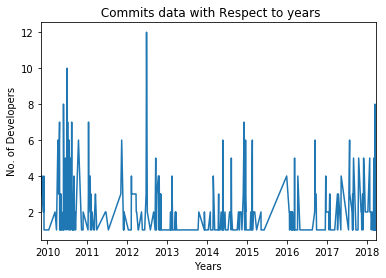

In [500]:
# Commits perform by developers each years
plt.figure()
Commits_data.plot()
plt.title(" Commits data with Respect to years")
plt.ylabel("No. of Developers")
plt.xlabel("Years")
plt.show()

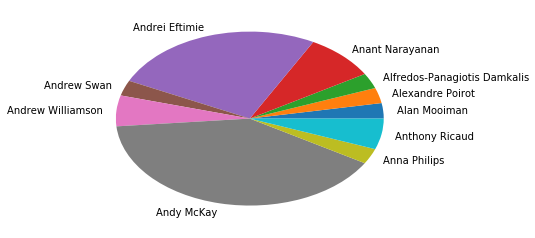

In [502]:
# This pie chart shows how much commits are performs by any developers

Author_names = simplified_data.Author_name.tolist()
names=np.array(Author_names) # I converted dataframes into array here for getting names of developers
names= np.unique(names) # removing duplicate names here as developers has perform more commits
commits=np.array(Authors_total) # this will provide the total commits
plt.figure()
p = plt.pie(commits[0:10], labels=names[0:10])


Text(0.5,1,'Commits yearly data')

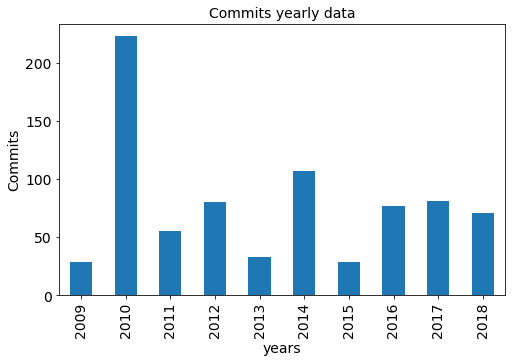

In [503]:
# bar chart representation of commits per year
p =yearly_data.plot.bar(figsize=(8,5),fontsize=14)
p.set_xlabel("years",fontsize=14)
p.set_ylabel("Commits",fontsize=14)
p.set_title("Commits yearly data",fontsize=14)

Data shows commits of developers applied each years and  contribution of developers to open source Community each year

### Following Ananlysis shows Developers and thier Public repositories on Github

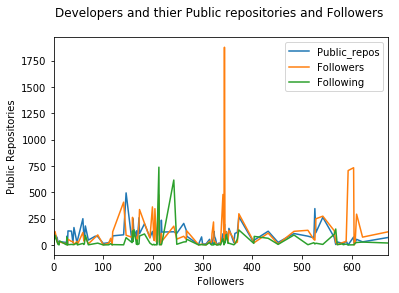

In [504]:
# developers with thier Followers and Follwoings
plt.figure()
simplified_developers_data.plot()
plt.title("Developers and thier Public repositories and Followers \n")
plt.ylabel("Public Repositories")
plt.xlabel("Followers")
plt.show()

Text(0.5,1,'Developers and thier Repositores')

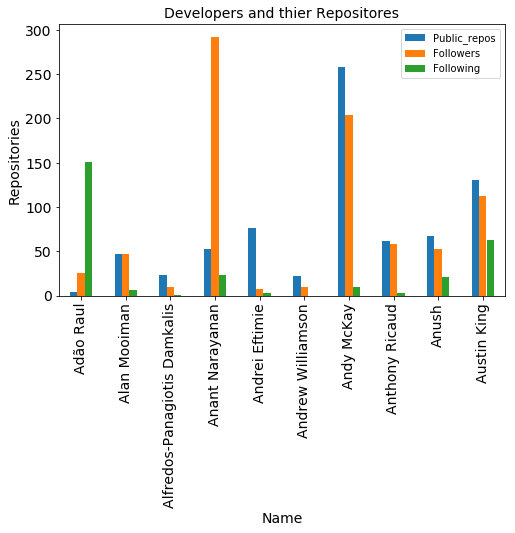

In [505]:
# which developers have high Followers 
p = Developers_repos[0:10].plot.bar(figsize=(8,5),fontsize=14)
p.set_xlabel("Name",fontsize=14)
p.set_ylabel("Repositories",fontsize=14)
p.set_title("Developers and thier Repositores",fontsize=14)


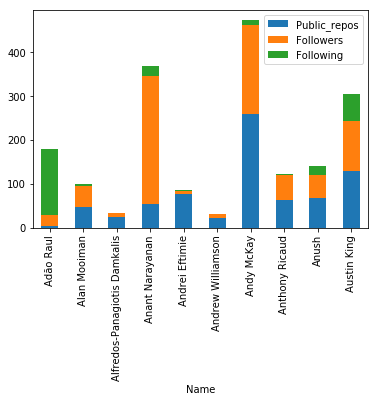

In [506]:
p = Developers_repos[0:10].plot.bar(stacked=True)

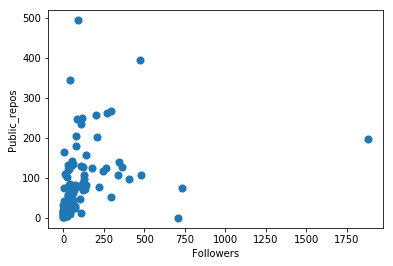

In [507]:
Developers_repos.plot.scatter(x="Followers", y="Public_repos", s=50 )

C:\Users\UCD\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000234F4125C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000234F38C9F28>]], dtype=object)

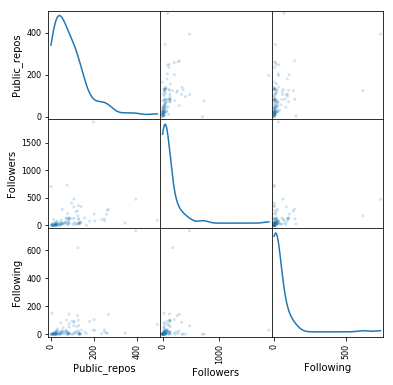

In [508]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(simplified_developers_data, alpha=0.2, figsize=(6, 6), diagonal='kde')

### Final Manipulation, Exploration and Visualisation

Final Analysis shows ratio of public source code available and Followers

Developers and Repositories

In [510]:
Developers_withrepos=simplified_developers_data.groupby("Public_repos")
repos_data = Developers_withrepos.mean()
print(repos_data[20:50])

              Followers  Following
Public_repos                      
28                  4.0        2.0
29                 74.0       27.0
31                 28.0       38.0
33                  0.0        0.0
34                 29.0        0.0
37                 29.5       11.5
42                  4.0        0.0
43                 12.0        1.0
44                 63.0       12.0
46                 16.0       41.0
47                 47.0        6.0
48                102.0       17.0
52                 39.0       10.0
53                163.5       23.0
57                 30.0       47.0
58                 28.0        7.0
62                 58.0        3.0
67                 52.0       21.0
70                 66.0       17.0
71                 81.5       23.5
72                135.0      101.0
75                733.0        1.0
76                  7.0        3.0
77                218.0        0.0
79                 95.0       17.0
80                 33.0        4.0
83                10

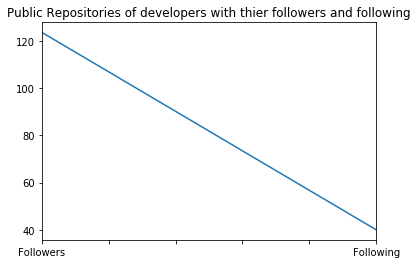

In [511]:
plt.figure()
repos_data.mean().plot()
plt.title("Public Repositories of developers with thier followers and following")
plt.show()

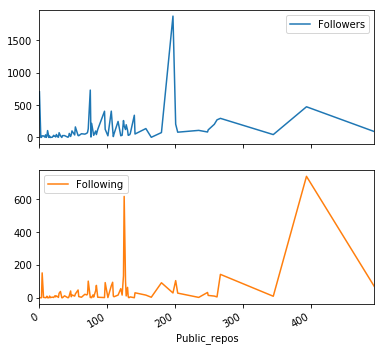

In [512]:
repos_data.plot(subplots=True, figsize=(6, 6));

 This data will further aid me in my research to see which type of refactoring the developers usually apply and either
    the practices of developers help in improving the Code quality